In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
def get_ordered_list(series):
    dict_ = series.value_counts().to_dict()
    package = [(key,value) for key, value in dict_.items()]
    package.sort(key=lambda item: item[0], reverse=True) 
    return package

def plot_ordered_list(package, log=False):
    plt.figure(figsize=(20, 10))
    plt.scatter([x for x, y in package], [np.log10(y) if log else y for x, y in package], s=5)

# Loading data

In [3]:
# read csv
yellow_4 = pd.read_csv('raw_data/yellow_tripdata_2020-04.csv')
yellow_5 = pd.read_csv('raw_data/yellow_tripdata_2020-05.csv')
yellow_6 = pd.read_csv('raw_data/yellow_tripdata_2020-06.csv')

yellow = yellow_4.append(yellow_5).append(yellow_6)
old_shape = yellow.shape

# Drop unuseful columns

In [4]:
# Since tip/fare/total/trip_distance do not depend on these columns 
yellow = yellow.drop(['store_and_fwd_flag', 'extra', 'tolls_amount', 'congestion_surcharge'], axis=1)

# Clean by Rule

In [5]:
for colname in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']:
    yellow[colname] = pd.to_datetime(yellow[colname])
    
# restrict data in the valid time in 2019
yellow = yellow.loc[(yellow['tpep_pickup_datetime'] <= datetime.strptime("2020-06-30 23:59:59", '%Y-%m-%d %H:%M:%S')) &
                    (yellow['tpep_pickup_datetime'] >= datetime.strptime("2020-04-01 00:00:00", '%Y-%m-%d %H:%M:%S'))]

yellow = yellow.loc[(yellow['tpep_dropoff_datetime'] <= datetime.strptime("2020-06-30 23:59:59", '%Y-%m-%d %H:%M:%S')) &
                    (yellow['tpep_dropoff_datetime'] >= datetime.strptime("2020-04-01 00:00:00", '%Y-%m-%d %H:%M:%S'))]

In [6]:
# suspect new vendor, but inconsistent with data rule 
yellow = yellow.loc[yellow['VendorID'] != 4]

yellow = yellow.loc[yellow['RatecodeID'].isin([1,2,3,4,5,6])]

# suspect coupon???? 
# remove invalid values
yellow = yellow.loc[yellow['fare_amount'] >= 2.5]

yellow = yellow.loc[yellow['total_amount'] >= 2.5]

yellow = yellow.loc[yellow['mta_tax'] == 0.5]

yellow = yellow.loc[yellow['improvement_surcharge'] == 0.3]

In [7]:
# this is illegal 
# remove invalid passenger_count (0<passenger_count<=6)
yellow = yellow.loc[(yellow['passenger_count'] > 0) & (yellow['passenger_count'] <= 6)]

yellow = yellow.loc[(yellow['tip_amount'] >0)]

# we only want credit card. cash payment does not record tip. 
yellow = yellow.loc[yellow['payment_type'] == 1]

In [8]:
# remove the missing values 
yellow = yellow.dropna()

## box plot before removing outliers

Text(0.5, 1.0, 'box plot of tip_distance')

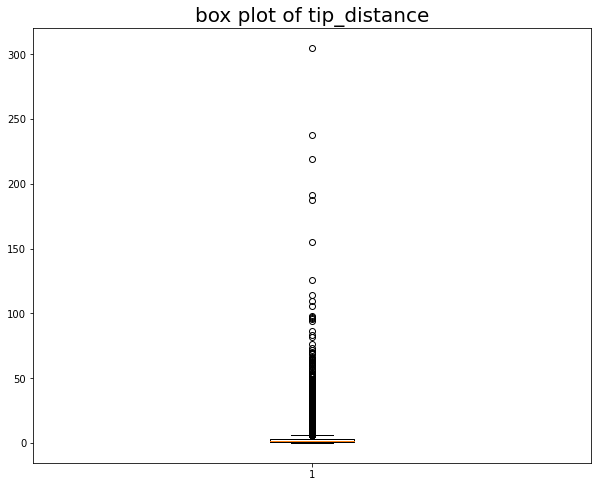

In [9]:
# box plot of trip distance, tip_amount, fare_amount
plt.figure(figsize=(10,8))
plt.boxplot(yellow['trip_distance'])
plt.title('box plot of tip_distance', fontsize=20)

Text(0.5, 1.0, 'box plot of fare and tip amount')

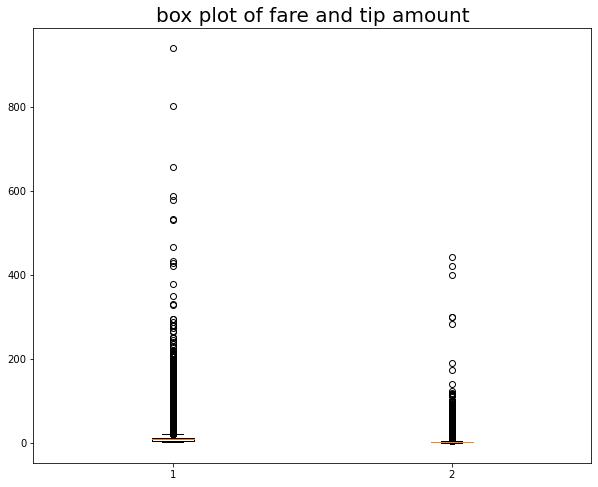

In [10]:
plt.figure(figsize=(10,8))
col_amount = ['fare_amount', 'tip_amount']
plt.boxplot(yellow[col_amount])
plt.title('box plot of fare and tip amount', fontsize=20)

# Clean by outlier

In [11]:
#after examining map, get radius, deduct plausible range as 50 miles
yellow = yellow.loc[(yellow['trip_distance'] > 0) & (yellow['trip_distance'] <= 50)]

yellow['tip_percent'] = yellow['tip_amount'] / yellow['fare_amount']

col = ['tip_percent', 'fare_amount']
Q1 = yellow[col].quantile(0.25)
Q3 = yellow[col].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range
filter_a = ((yellow[col] >= Q1 - 6 * IQR) & (yellow[col] <= Q3 + 6 * IQR)).all(axis=1)
yellow = yellow.loc[filter_a]

Text(0.5, 1.0, 'box plot of fare and tip amount (outliers removed)')

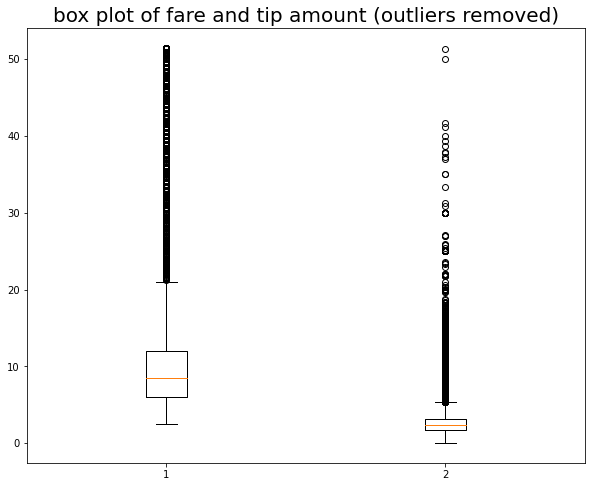

In [12]:
plt.figure(figsize=(10,8))
plt.boxplot(yellow[col_amount])
plt.title('box plot of fare and tip amount (outliers removed)', fontsize=20)

# Generate and clean by duration 

In [13]:
yellow['date'] = yellow['tpep_pickup_datetime'].dt.normalize()
# restrict the duration
yellow['duration'] = yellow['tpep_dropoff_datetime'] - yellow['tpep_pickup_datetime']
yellow['duration'] = yellow['duration'].dt.seconds / 60

# remove invalid duration 
yellow = yellow.loc[(yellow['duration'] > 0)]

# Generate date type

In [14]:
yellow.loc[yellow['date'].dt.dayofweek <= 5, 'date_type'] = 'Workday'
yellow.loc[yellow['date'].dt.dayofweek > 5, 'date_type'] = 'Weekend'

cal = calendar()
holidays = cal.holidays(start='2020-04-01', end='2020-06-30')
yellow.loc[yellow['date'].isin(holidays), 'date_type'] = 'Holiday'

# Generate income per unit time 

In [15]:
yellow['fare_per_minute'] = yellow['fare_amount'] / yellow['duration']

# Combine weather dataset

In [16]:
weather = pd.read_csv('preprocessed_data/2020_weather_processed.csv')

In [17]:
yellow['date_str'] = yellow['date'].astype(str)
yellow = pd.merge(yellow, weather, left_on='date_str', right_on='DATE').drop('DATE', axis=1)

# time of day

In [18]:
# 0=00:00-01:00 23=23:00-24:00
yellow['time_of_day'] = yellow['tpep_pickup_datetime'].dt.hour

# finally, write to disk

In [19]:
yellow.to_csv('preprocessed_data/2020_yellow_processed.csv', index=False)

In [20]:
f'{yellow.shape[0] / old_shape[0]:.2%}'

'47.49%'